In [1]:
%matplotlib widget
# other options for matplotlib are: `widget`, `ipympl`, `notebook`

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

In [165]:
column_names = ['atom', 'x', 'y', 'z']
# sI_Reference_replicated_once.xyz
df = pd.read_csv('/Users/nicksmits/chee494/reference_files/sI_Reference_replicated_once.xyz',
                 sep='\s+',
                 names=column_names,
                 skiprows=2)
# the `sep='\s+` is necessary because I want to use whitespace
# as the separator and not just `sep=" "`

In [166]:
df

,atom,x,y,z
0,O,0.000000,0.000000,3.006056
1,O,0.000000,0.000000,9.023943
2,O,0.000000,2.320827,1.421946
3,O,0.000000,2.320827,10.608054
4,O,0.000000,9.709172,1.421946
...,...,...,...,...
271,H,19.726071,3.195408,5.240990
272,H,17.578236,8.346895,6.032925
273,H,16.360800,8.834591,6.789010
274,H,20.008415,7.547020,6.010308


In [167]:
# Get the oxygen atoms only that for the cage 
oxygen_df = df[df['atom'] == 'O']

# oxygen_df = oxygen_df.sample(frac=1)

oxygen_df

,atom,x,y,z
0,O,0.000000,0.000000,3.006056
1,O,0.000000,0.000000,9.023943
2,O,0.000000,2.320827,1.421946
3,O,0.000000,2.320827,10.608054
4,O,0.000000,9.709172,1.421946
...,...,...,...,...
179,O,22.636490,6.015000,3.694172
180,O,16.621249,3.694654,6.015000
181,O,19.465622,3.694654,6.015000
182,O,16.621249,8.335346,6.015000


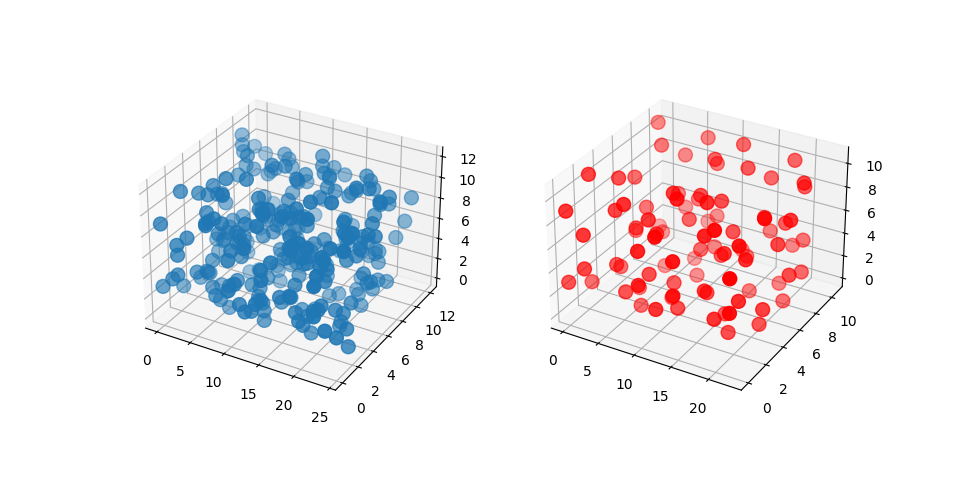

In [168]:
# Plot 3D atoms point clouds

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Plot all atoms
ax.scatter(df['x'], df['y'], df['z'],
           marker='o',
           s=100)
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Plot oxgygens only 
ax.scatter(oxygen_df['x'], oxygen_df['y'], oxygen_df['z'],
            marker='o',
            s=100, 
            c='r')
plt.show()

In [169]:
# def dist(P, Q):
#     return np.sqrt((P[0]-Q[0])**2 + (P[1]-Q[1])**2 + (P[2]-Q[2])**2)

In [170]:
# Known HBond atoms
# oxygen_df.iloc[20]
# oxygen_df.iloc[13][:]

In [171]:
# Ball park HBond / FIVE_RING_TOL / SIX_RING_TOL Dist value 
# dist(oxygen_df.iloc[7][1:], oxygen_df.iloc[6][1:]) / dist(oxygen_df.iloc[7][1:], oxygen_df.iloc[13][1:])

In [230]:
HBOND_DIST = 2.9
HBOND_DIST_TOL = 0.75
FIVE_RING_TOL = 0.2
SIX_RING_TOL = 0.25
CAGE_HEIGHT = 6.015
CAGE_HEIGHT_TOL = 0.2
# CUP_TILT_TOL = 0.1

class Graph:
    def __init__(self, verticies): # input a dataframe with 0 = index, 1,2,3 = x,y,z
        # Create all verticies and find neighbours for each vertex
        self.verticies = []
        for i in range(len(verticies)):
            self.verticies.append(self.Vertex(
                i, 
                verticies.iloc[i][1], ### CHANGE THIS (hardcoding is bad)
                verticies.iloc[i][2],
                verticies.iloc[i][3]
            ))
        
        # Populate neighbours for each vertex
        for vertex in self.verticies:
            vertex.populate_neighbours(self.verticies)

        self.closeable = False # Closeable ring flag

        self.five_ring = [] # Temporary variable for 5 membered rings
        self.five_ring_list = [] # List of 5 membered rings

        self.six_ring = [] # Temporary variable for 6 membered rings
        self.six_ring_list = [] # List of 6 membered rings

        self.cup_6_1_5_6_list = [] # List of 6_1_5_12 cups

        self.cage_6_2_5_12_list = [] # List of 6_2_5_12 cages
            

    ## Recurvise depth-first search for PENTAGONAL rings
    def fiveDFSRingFinder(self, start_index, itter):
        # Get the vertex from the list of all verticies in the graph
        vertex = self.verticies[start_index]
        vertex.visited = True

        # Check if the current sequence of 3 points in already in a ring, if so, don't continue
        if itter >= 2:
            for ring in self.five_ring_list:
                for i in range(5):
                    if i == 3: # Edge case
                        if {vertex, vertex.predecessor, vertex.predecessor.predecessor} == {ring.verticies[i], ring.verticies[i+1], ring.verticies[0]}:
                            return
                    elif i == 4: # Edge case
                        if {vertex, vertex.predecessor, vertex.predecessor.predecessor} == {ring.verticies[i], ring.verticies[0], ring.verticies[1]}:
                            return
                    else:
                        if {vertex, vertex.predecessor, vertex.predecessor.predecessor} == {ring.verticies[i], ring.verticies[i+1], ring.verticies[i+2]}:
                            return

        # Check if the sequence of 4 points (formed on the 3rd itteration) is closeable via a 5th point
        if itter == 3:
            # If any of the starting point's neighbours are neighbours of the current vertex's 3rd predecessor, the ring is closed
            for starting_point_neighbour in vertex.predecessor.predecessor.predecessor.neighbours:
                if vertex.is_neighbour(starting_point_neighbour):
                    # print("Close ring: " + str(starting_point_neighbour.index) + ": (" + str(starting_point_neighbour.x) + ", " + str(starting_point_neighbour.y) + ", " + str(starting_point_neighbour.z) + ")")
                    self.closeable = True
                    self.five_ring.append(starting_point_neighbour)
                    return
                
        if not self.closeable: # Only run if the ring has not been closed (to avoid uneccesary computation)
            # Loop through each neighbour of the current vertex 
            for neighbour in vertex.neighbours:
                # print(itter)
                if not neighbour.visited and itter < 4 and not self.closeable:
                    # print(str(neighbour.index) + ": (" + str(neighbour.x) + ", " + str(neighbour.y) + ", " + str(neighbour.z) + ")")

                    # The neighbour's predecessor is now the current vertex (used for backtracing)
                    neighbour.predecessor = vertex

                    # Check the second vertex in the sequence is 1.6 times the HBond distance from the starting point R(i, i+2) = 1.6*a
                    if itter >= 2:
                        if abs(1.6*vertex.dist(neighbour) - neighbour.dist(neighbour.predecessor.predecessor)) < FIVE_RING_TOL:
                            self.fiveDFSRingFinder(neighbour.index, itter + 1) # Recursion
                            if self.closeable:
                                self.five_ring.append(neighbour) # Only add to the ring variable if it is closable            
                    else:
                        if neighbour.neighbours is not None:
                            self.fiveDFSRingFinder(neighbour.index, itter + 1) # Recursion
                        if self.closeable:
                            self.five_ring.append(neighbour) # Only add to the ring if it is closeable



    ## Recurvise depth-first search for HEXAGONAL rings
    def sixDFSRingFinder(self, start_index, itter):
        # Get the vertex from the list of all verticies in the graph
        vertex = self.verticies[start_index]
        vertex.visited = True

        # Check if the current sequence of 3 points in already in a ring, if so, don't continue
        if itter >= 2:
            for ring in self.six_ring_list:
                for i in range(6):
                    if i == 4: # Edge case
                        if {vertex, vertex.predecessor, vertex.predecessor.predecessor} == {ring.verticies[i], ring.verticies[i+1], ring.verticies[0]}:
                            return
                    elif i == 5: # Edge case
                        if {vertex, vertex.predecessor, vertex.predecessor.predecessor} == {ring.verticies[i], ring.verticies[0], ring.verticies[1]}:
                            return
                    else:
                        if {vertex, vertex.predecessor, vertex.predecessor.predecessor} == {ring.verticies[i], ring.verticies[i+1], ring.verticies[i+2]}:
                            return

        # Check if the sequence of 4 points (formed on the 3rd itteration) is closeable via a 5th point
        if itter == 4:
            # If any of the starting point's neighbours are neighbours of the current vertex's 3rd predecessor, the ring is closed
            for starting_point_neighbour in vertex.predecessor.predecessor.predecessor.predecessor.neighbours:
                if vertex.is_neighbour(starting_point_neighbour):
                    # print("Close ring: " + str(starting_point_neighbour.index) + ": (" + str(starting_point_neighbour.x) + ", " + str(starting_point_neighbour.y) + ", " + str(starting_point_neighbour.z) + ")")
                    self.closeable = True
                    self.six_ring.append(starting_point_neighbour)
                    return
                
        if not self.closeable: # Only run if the ring has not been closed (to avoid uneccesary computation)
            # Loop through each neighbour of the current vertex 
            for neighbour in vertex.neighbours: 
                # print(itter)
                if not neighbour.visited and itter < 5 and not self.closeable:
                    # print(str(neighbour.index) + ": (" + str(neighbour.x) + ", " + str(neighbour.y) + ", " + str(neighbour.z) + ")")

                    # The neighbour's predecessor is now the current vertex (used for backtracing)
                    neighbour.predecessor = vertex

                    # Check the second vertex in the sequence is 1.6 times the HBond distance from the starting point R(i, i+2) = 1.6*a
                    if itter >= 3:
                        if abs(2*vertex.dist(neighbour) - neighbour.dist(neighbour.predecessor.predecessor.predecessor)) < SIX_RING_TOL:
                            self.sixDFSRingFinder(neighbour.index, itter + 1) # Recursion
                            if self.closeable:
                                self.six_ring.append(neighbour) # Only add to the ring variable if it is closable
                    else:
                        self.sixDFSRingFinder(neighbour.index, itter + 1) # Recursion
                        if self.closeable:
                            self.six_ring.append(neighbour) # Only add to the ring if it is closeable


    def clear(self):
        # Reset graph to default
        self.closeable = False # No longer closeable
        for vertex in self.verticies: 
            vertex.predeccesor = None # Remove vertext predecessor 'memory'
            vertex.visited = False
            random.shuffle(vertex.neighbours) # Shuffle the neighbors list of the vertex


    def add_ring_to_matrix(self, start_index):
        # If we have found a ring (len = 4 since we don't add the start index to the list in DFS)
        if len(self.five_ring) == 4:
            self.five_ring.append(self.verticies[start_index]) # Add the starting O2 to the list
            # print("full")

            self.five_ring_list.append(self.Ring(self.five_ring))

            self.five_ring = [] # Reset the ring list
            
        # If we have found a ring (len = 5 since we don't add the start index to the list in DFS)
        elif len(self.six_ring) == 5:
            self.six_ring.append(self.verticies[start_index])
            # print("full")

            self.six_ring_list.append(self.Ring(self.six_ring))

            self.six_ring = [] # Reset the ring list
            
        # Reset the ring lists if no ring is found
        else:
            self.five_ring = []
            self.six_ring = []


    def six_find_neighbouring_five_rings(self):
        # For each hexagonal ring, find neighbouring pentagonal rings
        for hex_ring in self.six_ring_list:
            for pent_ring in self.five_ring_list:  
                for i in range(6): 
                    for j in range(5):
                        if i == 5 and j == 4:
                            if {hex_ring.verticies[i], hex_ring.verticies[0]} == {pent_ring.verticies[j], pent_ring.verticies[0]}: 
                                hex_ring.neighbouring_rings.add(pent_ring)
                                pent_ring.neighbouring_rings.add(hex_ring)
                                hex_ring.coordination += 1
                                pent_ring.coordination += 1
                        elif i == 5:
                            if {hex_ring.verticies[i], hex_ring.verticies[0]} == {pent_ring.verticies[j], pent_ring.verticies[j+1]}: 
                                hex_ring.neighbouring_rings.add(pent_ring)
                                pent_ring.neighbouring_rings.add(hex_ring)
                                hex_ring.coordination += 1
                                pent_ring.coordination += 1
                        elif j == 4:
                            if {hex_ring.verticies[i], hex_ring.verticies[i+1]} == {pent_ring.verticies[j], pent_ring.verticies[0]}: 
                                hex_ring.neighbouring_rings.add(pent_ring)
                                pent_ring.neighbouring_rings.add(hex_ring)
                                hex_ring.coordination += 1
                                pent_ring.coordination += 1
                        else:
                            if {hex_ring.verticies[i], hex_ring.verticies[i+1]} == {pent_ring.verticies[j], pent_ring.verticies[j+1]}: 
                                hex_ring.neighbouring_rings.add(pent_ring)
                                pent_ring.neighbouring_rings.add(hex_ring)
                                hex_ring.coordination += 1
                                pent_ring.coordination += 1

    # TODO: Make function to find all of the neighbours of each pentagonal ring
    def five_find_neighbouring_five_rings(self):
        # For each pentagonal ring, find neighbouring pentagonal rings
        for i in range(len(self.five_ring_list) - 1):
            for j in range(i + 1, len(self.five_ring_list)):
                for k in range(5):
                    for l in range(5):
                        if k == 4 and l == 4:
                            if {self.five_ring_list[i].verticies[k], self.five_ring_list[i].verticies[0]} == {self.five_ring_list[j].verticies[l], self.five_ring_list[j].verticies[0]}: 
                                self.five_ring_list[i].neighbouring_rings.add(self.five_ring_list[j])
                                self.five_ring_list[j].neighbouring_rings.add(self.five_ring_list[i])
                                self.five_ring_list[i].coordination += 1
                                self.five_ring_list[j].coordination += 1
                        elif k == 4:
                            if {self.five_ring_list[i].verticies[k], self.five_ring_list[i].verticies[0]} == {self.five_ring_list[j].verticies[l], self.five_ring_list[j].verticies[l+1]}: 
                                self.five_ring_list[i].neighbouring_rings.add(self.five_ring_list[j])
                                self.five_ring_list[j].neighbouring_rings.add(self.five_ring_list[i])
                                self.five_ring_list[i].coordination += 1
                                self.five_ring_list[j].coordination += 1
                        elif l == 4:
                            if {self.five_ring_list[i].verticies[k], self.five_ring_list[i].verticies[k+1]} == {self.five_ring_list[j].verticies[l], self.five_ring_list[j].verticies[0]}: 
                                self.five_ring_list[i].neighbouring_rings.add(self.five_ring_list[j])
                                self.five_ring_list[j].neighbouring_rings.add(self.five_ring_list[i])
                                self.five_ring_list[i].coordination += 1
                                self.five_ring_list[j].coordination += 1
                        else:
                            if {self.five_ring_list[i].verticies[k], self.five_ring_list[i].verticies[k+1]} == {self.five_ring_list[j].verticies[l], self.five_ring_list[j].verticies[l+1]}: 
                                self.five_ring_list[i].neighbouring_rings.add(self.five_ring_list[j])
                                self.five_ring_list[j].neighbouring_rings.add(self.five_ring_list[i])
                                self.five_ring_list[i].coordination += 1
                                self.five_ring_list[j].coordination += 1


    # TODO: Fix this function, it is not consistently finding 3 cups
    # Find 6_1_5_6 rings. 1 fully coordinated hexagon with 5 pentagons, each of the pentagons share an edge with the hexagon and 2 other pentagons
    def find_6_1_5_6_cups(self):
        for hex_ring in self.six_ring_list:
            if hex_ring.coordination >= 6: # If the hexagon is fully coordinated
                # print("Fully coordinated hexagon found")
                # hex_ring.print_ring()
                hex_ring.visited = True
                for pent_ring in hex_ring.neighbouring_rings: # For each neighbouring pentagon
                    stack = [(pent_ring, 0)] # Add the pentagon to the stack with a depth of 0
                    skip = False
                    # Itterative depth first search
                    while stack: 
                        current_ring, depth = stack.pop()
                        current_ring.visited = True
                        # print(f"Visited node at depth {depth}")
                        # current_ring.print_ring()
                        
                        if not skip:
                            # Check if the current ring is already in a cup
                            if depth == 0 and self.cup_6_1_5_6_list:
                                for cup_6_1_5_6 in self.cup_6_1_5_6_list:
                                    if current_ring in cup_6_1_5_6.rings:
                                        skip = True # Don't continue if the ring is already in a cup
                                        break
                        
                            if depth > 4: # At a depth of 4, we are on the 5th pentagon
                                # print("check")
                                if current_ring.predecessor.predecessor.predecessor.predecessor.predecessor in current_ring.neighbouring_rings:# Check if the 5th ring is the root, then we have a 6_1_5_12 cup
                                    # print("FOUND")
                                    self.cup_6_1_5_6_list.append(self.Cup([hex_ring,
                                                                            current_ring.predecessor.predecessor.predecessor.predecessor.predecessor, 
                                                                            current_ring.predecessor.predecessor.predecessor.predecessor, 
                                                                            current_ring.predecessor.predecessor.predecessor, 
                                                                            current_ring.predecessor.predecessor, 
                                                                            current_ring.predecessor,
                                                                            current_ring])) # Add the cup to the list
                                    break
                                    
                            for ring in current_ring.neighbouring_rings: # DFS
                                if not ring.visited and ring.is_neighbour_of(hex_ring): # Ring needs to be a neighbour of the hexagon
                                    if current_ring.predecessor is not None:
                                        if ring.neighbour_orientation(hex_ring) == current_ring.predecessor.neighbour_orientation(hex_ring): # Ring needs to be on the same side of the hexagon as the previous ring
                                            ring.predecessor = current_ring
                                            stack.append((ring, depth + 1)) # Add the ring to the stack with a depth of 1 greater than the current ring
                                    else:
                                        ring.predecessor = current_ring
                                        stack.append((ring, depth + 1))
                    
                    for ring in self.five_ring_list:    
                        ring.clear()


    # TODO: Find 6_2_5_12 cages. Cages are two cups, where each of the pentagonal rings on one cup have 2 neighbouring pentagonal rings on another cup
    def find_6_2_5_12_cages(self):
        for i in range(len(self.cup_6_1_5_6_list) - 1):
            common_edge_count = 0
            cup_1 = self.cup_6_1_5_6_list[i]
            for j in range(i, len(self.cup_6_1_5_6_list)):
                cup_2 = self.cup_6_1_5_6_list[j]
                if np.isclose(np.dot(cup_1.oriented_normal, (-1)*cup_2.oriented_normal), 1) and cup_1.base != cup_2.base:
                    if abs(cup_1.base_centroid().dist(cup_2.base_centroid()) - CAGE_HEIGHT) < CAGE_HEIGHT_TOL:
                        for k in range(1, len(cup_1.rings)):
                            for j in range(1, len(cup_2.rings)):
                                if cup_1.rings[k].is_neighbour_of(cup_2.rings[j]):
                                    common_edge_count += 1
                        print(common_edge_count)
                        if common_edge_count == 12:
                            self.cage_6_2_5_12_list.append(self.Cage([cup_1, cup_2]))                                       

    def print_rings(self):
        # Print all rings
        count = 0
        for ring in self.five_ring_list:
            count += 1
            print("PENT RING " + str(count))
            for vertex in ring.verticies:
                print(str(vertex.index) + ": (" + str(vertex.x) + ", " + str(vertex.y) + ", " + str(vertex.z) + ")")
            print("\n")

        count = 0
        for ring in self.six_ring_list:
            count += 1
            print("HEX RING " + str(count))
            for vertex in ring.verticies:
                print(str(vertex.index) + ": (" + str(vertex.x) + ", " + str(vertex.y) + ", " + str(vertex.z) + ")")
            print("\n")

    def plot_rings(self):
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        for ring in self.five_ring_list:
            for vertex in ring.verticies:
                if len(ring.verticies) == 6:
                    ax.scatter(vertex.x, vertex.y, vertex.z,
                            marker='o',
                            s=100,
                            c='b')
                else:  
                    ax.scatter(vertex.x, vertex.y, vertex.z,
                            marker='o',
                            s=100,
                            c='r') 
        plt.show()    
            
    def print_cups(self):
        # Print all cups
        count = 0
        for cup in self.cup_6_1_5_6_list:
            count += 1
            print("CUP " + str(count))
            for ring in cup.rings:
                ring.print_ring()
            print("\n")

    def plot_cups(self):
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        for cup in self.cup_6_1_5_6_list:
            for ring in cup.rings:
                for vertex in ring.verticies: 
                    ax.scatter(vertex.x, vertex.y, vertex.z,
                            marker='o',
                            s=100,
                            c='r')
            for vertex in cup.base.verticies:
                ax.scatter(vertex.x, vertex.y, vertex.z,
                            marker='o',
                            s=100,
                            c='b')
        plt.show()

    def print_cages(self):
        # Print all cages
        count = 0
        for cage in self.cage_6_2_5_12_list:
            count += 1
            print("CAGE " + str(count))
            cage.print_cage()
            cage.plot_cage()
    
    def plot_cages(self):
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        for cage in self.cage_6_2_5_12_list:
            for cup in cage.cups:
                for ring in cup.rings:
                    for vertex in ring.verticies:
                        ax.scatter(vertex.x, vertex.y, vertex.z,
                                marker='o',
                                s=100,
                                c='r')
                for vertex in cup.base.verticies:
                    ax.scatter(vertex.x, vertex.y, vertex.z,
                                marker='o',
                                s=100,
                                c='b')
        plt.show()
    
    class Ring():
        def __init__(self, verticies):
            self.verticies = verticies
            self.num_verticies = len(verticies)
            self.neighbouring_rings = set()
            self.coordination = 0
            self.visited = False
            self.predecessor = None

        # Finds and returns which side of the plane of the hexagon this ring is on.
        def neighbour_orientation(self, base_ring, return_oriented_normal=False):
            P = np.array([base_ring.verticies[0].x, base_ring.verticies[0].y, base_ring.verticies[0].z])
            Q = np.array([base_ring.verticies[1].x, base_ring.verticies[1].y, base_ring.verticies[1].z])
            R = np.array([base_ring.verticies[5].x, base_ring.verticies[5].y, base_ring.verticies[5].z])
            hex_vec_1 = Q - P
            hex_vec_2 = R - P
            hex_normal = np.cross(hex_vec_1, hex_vec_2)

            for vertex in self.verticies:
                if vertex not in base_ring.verticies:
                    N = np.array([vertex.x, vertex.y, vertex.z])
                    if return_oriented_normal:
                        return (hex_normal * np.sign(np.dot(hex_normal, N - P)))/np.linalg.norm(hex_normal)
                    return np.sign(np.dot(hex_normal, N - P))
            

        def print_neighbouring_rings(self):
            count = 0
            for ring in self.neighbouring_rings:
                count += 1
                print("NEIGHBOURING RING: " + str(count))
                for vertex in ring.verticies:
                    print(str(vertex.index) + ": (" + str(vertex.x) + ", " + str(vertex.y) + ", " + str(vertex.z) + ")")
                print("\n")

        def is_neighbour_of(self, ring):
            if self in ring.neighbouring_rings:
                return True

        def clear(self):
            self.visited = False
            self.predecessor = None
        
        def equals(self, ring):
            if set(self.verticies) == set(ring.verticies):
                return True
            return False
        
        def print_ring(self):
            for vertex in self.verticies:
                print(str(vertex.index) + ": (" + str(vertex.x) + ", " + str(vertex.y) + ", " + str(vertex.z) + ")")
            print("\n") 
        

    class Cage():
        def __init__(self, cups):
            self.cups = cups

        def print_cage(self):
            print("CAGE")
            for cup in self.cups:
                cup.print_cup()
            print("\n")

        def plot_cage(self):
            fig = plt.figure(figsize=plt.figaspect(0.5))
            ax = fig.add_subplot(1, 1, 1, projection='3d')
            for cup in self.cups:
                for ring in cup.rings:
                    for vertex in ring.verticies:
                        ax.scatter(vertex.x, vertex.y, vertex.z,
                                marker='o',
                                s=100,
                                c='r') # Red for the pentagons
                
                for vertex in cup.base.verticies:
                    ax.scatter(vertex.x, vertex.y, vertex.z,
                                marker='o',
                                s=100,
                                c='b') # blue for the hexagon base
            plt.show()

    class Cup():
        def __init__(self, rings):
            self.rings = rings #List of 1 hexagon (frist) and 5 pentagons
            self.base = rings[0]
            
            # Find the normal of the cup oriented with respect to its neighbours
            self.oriented_normal = self.rings[1].neighbour_orientation(self.base, return_oriented_normal=True)

        def base_centroid(self):
            x = 0
            y = 0
            z = 0
            for vertex in self.base.verticies:
                x += vertex.x
                y += vertex.y
                z += vertex.z
            return Graph.Vertex(0, x/6, y/6, z/6)
         
        def print_cup(self):
            print("CUP")
            for ring in self.rings:
                ring.print_ring()
            print("\n")

        # Makes a new plot of just the atoms in the cup
        def plot_cup(self):
            fig = plt.figure(figsize=plt.figaspect(0.5))
            ax = fig.add_subplot(1, 1, 1, projection='3d')

            # Plot all atoms
            for ring in self.rings:
                for vertex in ring.verticies:
                    ax.scatter(vertex.x, vertex.y, vertex.z,
                            marker='o',
                            s=100,
                            c='r') # Red for the pentagons
            for vertex in self.base.verticies:
                ax.scatter(vertex.x, vertex.y, vertex.z,
                            marker='o',
                            s=100,
                            c='b') # blue for the hexagon base
            plt.show()


    class Vertex:
        def __init__(self, i, x, y, z):
            self.index = i # Particle index in the xyz file 
            self.x = x 
            self.y = y
            self.z = z
            
            self.visited = False # Visited var
            
            self.neighbours = [] # List of first neighbours (array of Vertex objects)
            self.num_neighbours = 0
            
            self.predecessor = None # Predecessor for backtracking

        def populate_neighbours(self, verticies): # Takes in a list of verticies
            count = 0
            # For every vertex, find its neighbours
            for vertex in verticies:
                if self == vertex:
                    continue
                if self.is_neighbour(vertex):
                    # self.neighbours.add(vertex)
                    self.neighbours.append(vertex)
                    count += 1
            random.shuffle(self.neighbours) # Avoids bias in DFS (trying to avoid the same path being taken from the same vertex ... I think)
            self.num_neighbours = count
        
        def is_neighbour(self, Q):
            # If the current vertex (self) and the vertex Q are the toleranced HBond distance apart, they are neighbours
            if (abs(self.dist(Q) - HBOND_DIST) < HBOND_DIST_TOL):
                return True 
            return False 

        def dist(self, Q):
            # Simple euclidean distance calculation
            return np.sqrt((self.x-Q.x)**2 + (self.y-Q.y)**2 + (self.z-Q.z)**2) 
        

In [231]:
# Initialise the graph
g = Graph(oxygen_df)

In [232]:
# Find all PENTAGONAL and HEXAGONAL rings
for i in range(len(oxygen_df)):
    # Find all pentagonal rings
    g.fiveDFSRingFinder(i, 0)
    g.add_ring_to_matrix(i)
    g.clear()

    # Find all hexagonal rings
    g.sixDFSRingFinder(i, 0)
    g.add_ring_to_matrix(i) 
    g.clear()

# Print all unique rings 
g.print_rings()

print("Num PENT rings : " + str(len(g.five_ring_list)))
print("Num HEX rings : " + str(len(g.six_ring_list)))

PENT RING 1
16: (2.263324258, 3.712698698, 2.2096703028)
20: (3.7516756085, 2.2096703028, 3.712698698)
14: (2.3203463605, 0.0, 4.5928134905)
0: (0.0, 0.0, 3.0060563092)
2: (0.0, 2.3208274883, 1.4219459324)


PENT RING 2
1: (0.0, 0.0, 9.0239429426)
15: (2.3203463605, 0.0, 7.4371862425)
22: (3.7516756085, 2.2096703028, 8.3173017447)
17: (2.263324258, 3.712698698, 9.8203296708)
3: (0.0, 2.3208274883, 10.6080541615)


PENT RING 3
32: (8.2783241245, 2.2096703028, 3.712698698)
43: (7.4371862425, 3.694653506, 6.0149998665)
42: (4.5928134905, 3.694653506, 6.0149998665)
20: (3.7516756085, 2.2096703028, 3.712698698)
8: (6.0149998665, 1.4219459324, 2.3208274883)


PENT RING 4
21: (3.7516756085, 9.8203296708, 3.712698698)
44: (4.5928134905, 8.335346227, 6.0149998665)
45: (7.4371862425, 8.335346227, 6.0149998665)
33: (8.2783241245, 9.8203296708, 3.712698698)
9: (6.0149998665, 10.6080541615, 2.3208274883)


PENT RING 5
34: (8.2783241245, 2.2096703028, 8.3173017447)
43: (7.4371862425, 3.694653506, 6.

In [233]:
# Find neighbouring pentagonal rings for each hexagonal ring
g.six_find_neighbouring_five_rings()

# Find neighbouring pentagonal rings for each pentagonal ring
g.five_find_neighbouring_five_rings() 


In [234]:
ring_index = 1

g.six_ring_list[ring_index].print_neighbouring_rings()

NEIGHBOURING RING: 1
68: (15.7801113212, 2.2096703028, 8.3173017447)
63: (14.2917599707, 3.712698698, 9.8203296708)
49: (12.0284357127, 2.3208274883, 10.6080541615)
47: (12.0284357127, 0.0, 9.0239429426)
61: (14.3487820732, 0.0, 7.4371862425)


NEIGHBOURING RING: 2
32: (8.2783241245, 2.2096703028, 3.712698698)
28: (9.7666759441, 3.712698698, 2.2096703028)
48: (12.0284357127, 2.3208274883, 1.4219459324)
46: (12.0284357127, 0.0, 3.0060563092)
26: (9.7096538537, 0.0, 4.5928134905)


NEIGHBOURING RING: 3
47: (12.0284357127, 0.0, 9.0239429426)
49: (12.0284357127, 2.3208274883, 10.6080541615)
29: (9.7666759441, 3.712698698, 9.8203296708)
34: (8.2783241245, 2.2096703028, 8.3173017447)
27: (9.7096538537, 0.0, 7.4371862425)


NEIGHBOURING RING: 4
27: (9.7096538537, 0.0, 7.4371862425)
26: (9.7096538537, 0.0, 4.5928134905)
32: (8.2783241245, 2.2096703028, 3.712698698)
43: (7.4371862425, 3.694653506, 6.0149998665)
34: (8.2783241245, 2.2096703028, 8.3173017447)


NEIGHBOURING RING: 5
61: (14.348782

In [235]:
g.find_6_1_5_6_cups()

In [236]:
print("Num Cups:" + str(len(g.cup_6_1_5_6_list)))

Num Cups:9


In [237]:
list(g.six_ring_list[1].neighbouring_rings)[5].neighbour_orientation(g.six_ring_list[1])

1.0

In [238]:
g.six_ring_list[5].coordination

12

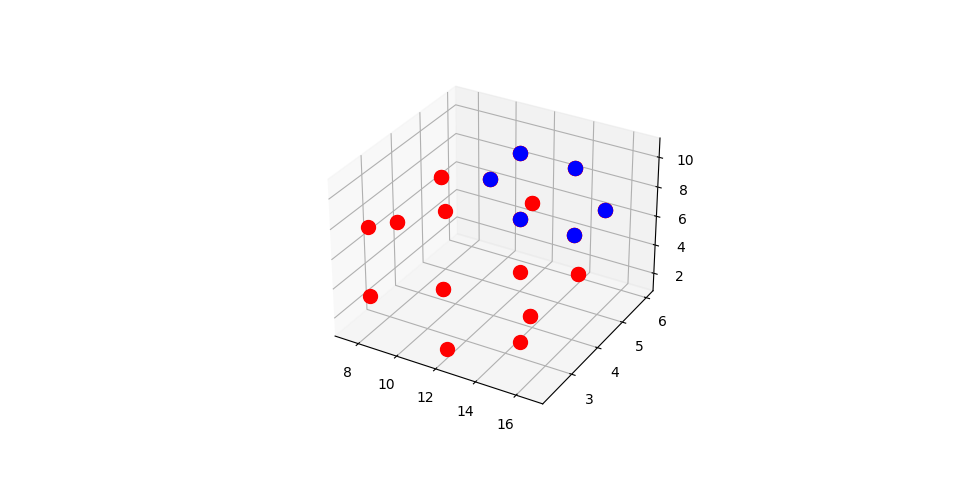

In [246]:
g.cup_6_1_5_6_list[4].plot_cup()

In [247]:
g.find_6_2_5_12_cages()
print("Num Cages: " + str(len(g.cage_6_2_5_12_list)))

12
12
12
Num Cages: 3


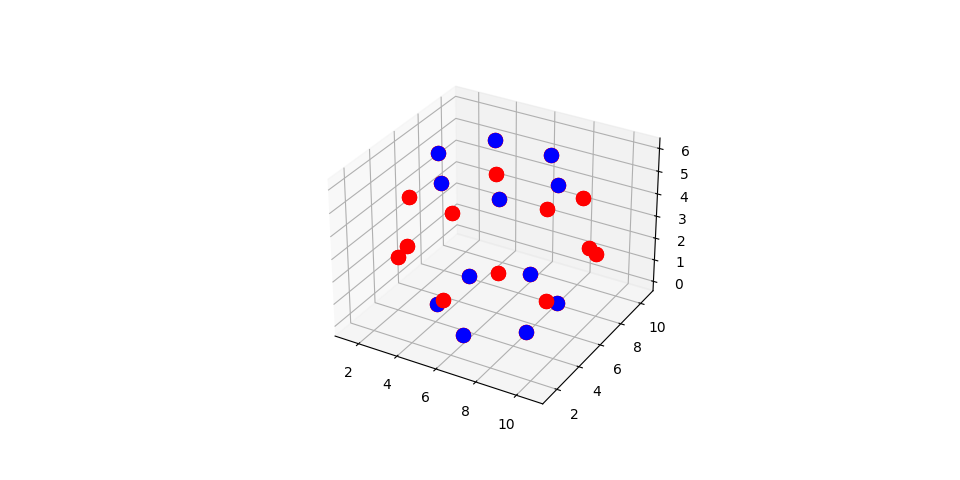

In [192]:
g.cage_6_2_5_12_list[0].plot_cage()

In [104]:
g.cup_6_1_5_6_list[0].base_centroid().dist(g.cup_6_1_5_6_list[2].base_centroid())

6.0149998665

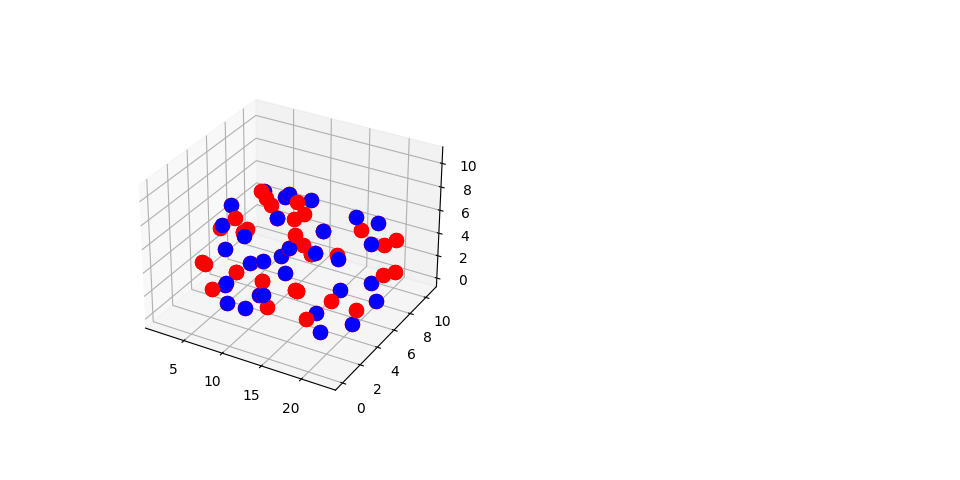

In [248]:
g.plot_cages()